In [1]:
import io
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import f1_score

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import Compose, Lambda, ToTensor, Normalize, Resize, RandomCrop, TenCrop, RandomHorizontalFlip

2024-03-27 03:44:31.796706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 03:44:31.796841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 03:44:32.083045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Some settings:
# --------------
train_files = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/train/*.tfrec'
valid_files = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/*.tfrec'
test_files  = '/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/test/*.tfrec'
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # hardware
n_epochs    = 10                                                            # number of training epochs
batch_size  = 20                                                           # training batch size
num_prints  = 10                                                            # number of losses to print per epoch
train_size  = 12753                                                        # number of training data samples
print_freq  = train_size // (batch_size * num_prints) + 1                  # print if iteration is a multiple of this
check_freq  = 1                                                            # save model if epoch is a multiple of this

In [3]:
# Utility functions:
# ------------------

def tfrecords_to_dataframe(fp, test = False):
    '''
    Parse data files into rows of a dataframe.
    
    arguments
    ---------
    fp : str
        Data files pattern.
        
    test : bool
        If true, data files correspond to testing data.
    '''
    def parse(pb, test = False):
        d = {'id': tf.io.FixedLenFeature([], tf.string), 'image': tf.io.FixedLenFeature([], tf.string)}
        if not test:
            d['class'] = tf.io.FixedLenFeature([], tf.int64)
        return tf.io.parse_single_example(pb, d)

    df = {'id': [], 'img': []} 
    if not test:
        df['lab'] = []
    for sample in tf.data.TFRecordDataset(glob.glob(fp)).map(lambda pb: parse(pb, test)):
        df['id'].append(sample['id'].numpy().decode('utf-8'))
        df['img'].append(sample['image'].numpy())
        if not test:
            df['lab'].append(sample['class'].numpy())
    return pd.DataFrame(df)

# ------------------------------------------------------------------------------------------------------------------------

def display_images(dataset, n, cols):
    '''
    Display a grid of labelled images of flowers.
    
    arguments
    ---------
    dataset : Dataset
        Dataset containing the flower images and labels.
        
    n : int
        Number of images to display.
        
    cols : int
        Number of columns in the grid.
    '''
    rows = n // cols if n % cols == 0 else n // cols + 1
    plt.figure(figsize = (2 * cols, 2 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img, lab = dataset[i]
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(str(lab))
        plt.axis('off')
    plt.show()

Let $X \sim \text{Uniform}[300, 640]$. 

As can be seen in the ``Trainset`` class below, each training sample is randomly scaled by sampling $X$, is randomly cropped to size $300$, and is flipped horizontally with probability $0.50$.

As can be seen in the ``Validset`` and ``Testset`` classes below, each validation and testing sample is scaled to the fixed sizes $372 \approx \mathbb{E}[X] - \sqrt{\mathbb{V}[X]}$ and $568 \approx \mathbb{E}[X] + \sqrt{\mathbb{V}[X]}$, each of which is then transformed into 10 new images (i.e., 5 crops of size 300 and the horizontal flip of each crop). In other words, each validation and testing image becomes 20. 

Training batches are set to size 20 whereas validation and testing batches are set to size 1. However, since each validation and testing image becomes 20 (as mentioned above), training, validation, and testing batch sizes are the same. 

As can be seen in the validation and testing loops below, the 20 model outputs that result from a validation or testing input are averaged. Intuitively, the randomness introduced during training is "averaged out" during validation and testing.

See section "3.4. Implementation" in https://arxiv.org/pdf/1512.03385.pdf. 

In [4]:
# Classes:
# --------

class Trainset(Dataset):
    '''
    Representation of the training dataset.
    '''
    def __init__(self, frac = 1):
        '''
        arguments
        ---------
        frac : float
            Fraction of data samples to keep.
            
            For example, if frac = 0.5, then a random sample of 50% 
            of the data is kept and the remaining 50% is discarded.
        '''
        super().__init__()
        self.df = tfrecords_to_dataframe(train_files).sample(frac = frac).reset_index(drop = True)
        self.t1 = Lambda(lambda b: Image.open(io.BytesIO(b)))
        self.t2 = Compose([RandomCrop(300), 
                           RandomHorizontalFlip(), 
                           ToTensor(), 
                           Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        transform = Compose([self.t1, Resize(np.random.randint(300, 641)), self.t2])
        sample = self.df.iloc[i]
        return transform(sample['img']), sample['lab']

# -------------------------------------------------------------------------------------------------------------------------    

class Evalset(Dataset):
    '''
    Representation of the evaluation datasets.
    '''
    def __init__(self, frac = 1, test = False):
        '''
        arguments
        ---------
        frac : float
            Fraction of data samples to keep.
            
            For example, if frac = 0.5, then a random sample of 50% 
            of the data is kept and the remaining 50% is discarded.
            
        test : bool
            If true, this dataset contains the testing data. 
            Otherwise, this dataset contains the validation data. 
        '''
        super().__init__()
        files = valid_files if not test else test_files
        self.df = tfrecords_to_dataframe(files, test).sample(frac = frac).reset_index(drop = True)
        self.transforms = [Compose([Lambda(lambda b: Image.open(io.BytesIO(b))), 
                                    Resize(scale), 
                                    TenCrop(300), 
                                    Lambda(lambda xs: torch.stack([ToTensor()(x) for x in xs])), 
                                    Lambda(lambda xs: torch.stack([Normalize([0.485, 0.456, 0.406], 
                                                                             [0.229, 0.224, 0.225])(x) for x in xs]))])
                           for scale in [372, 568]]
        self.test = test
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        sample = self.df.iloc[i]
        imgs = torch.stack([t(sample['img']) for t in self.transforms])
        return imgs, sample['lab'] if not self.test else sample['id']

# -------------------------------------------------------------------------------------------------------------------------    

class EfficientNetB0(nn.Module):
    '''
    EfficientNet B0 fine-tune.
    '''
    def __init__(self, n_classes, learnable_modules = ('classifier.1',)):
        '''
        arguments
        ---------
        n_classes : int
            Number of classification categories.
            
        learnable_modules : tuple
            Names of the modules to fine-tune.
        '''
        super().__init__()
        self.efficientnet_b0 = models.efficientnet_b0(weights = 'DEFAULT')
        self.efficientnet_b0.classifier[1] = nn.Linear(self.efficientnet_b0.classifier[1].in_features, n_classes)
        self.efficientnet_b0.requires_grad_(False)
        modules = dict(self.efficientnet_b0.named_modules())
        for name in learnable_modules:
            modules[name].requires_grad_(True)
        
    def forward(self, x):
        return F.log_softmax(self.efficientnet_b0(x), dim = 1)

In [5]:
# Training, validation, and testing data:
# ---------------------------------------
train_set    = Trainset()
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(Evalset(frac = 0.20), batch_size = 1, num_workers = 2)
test_loader  = DataLoader(Evalset(test = True), batch_size = 1, num_workers = 2)

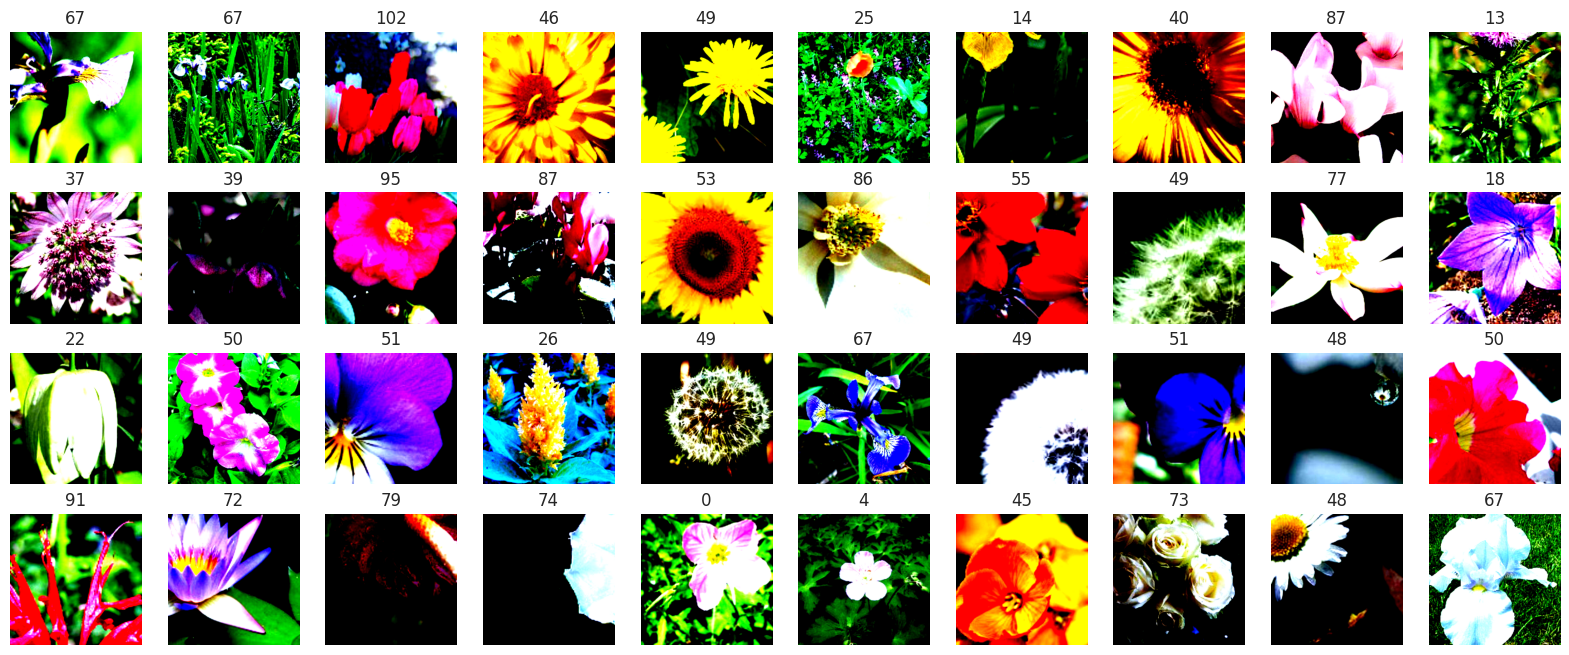

In [6]:
# Display some training images and labels:
# ----------------------------------------
display_images(train_set, n = 40, cols = 10)

In the optimizer below, we define five parameter groups (really two as the first four can be combined). 

The first four parameter groups consist of parameters pre-trained on ImageNet and the last parameter group consists of the final affine layer parameters which are trained from scratch. 

We set the pre-trained parameters' learning rate to 0.0001 and the "from scratch" parameters' learning rate to 0.001 -- that is, pre-trained parameters are fine-tuned using a learning rate which is an order of magnitude less than the learning rate of the from scratch parameters. 

The learning rate scheduler decays the learning rates of all groups to zero over the course of training.

In [7]:
# Modelling components:
# ---------------------
model = nn.DataParallel(EfficientNetB0(n_classes = 104, learnable_modules = ('features.5.2', 
                                                                             'features.6', 
                                                                             'features.7', 
                                                                             'features.8', 
                                                                             'classifier')))
model.to(device)

optimizer = torch.optim.Adam(params = [{'params': model.module.efficientnet_b0.features[5][2].parameters()}, 
                                       {'params': model.module.efficientnet_b0.features[6].parameters()}, 
                                       {'params': model.module.efficientnet_b0.features[7].parameters()},
                                       {'params': model.module.efficientnet_b0.features[8].parameters()},
                                       {'params': model.module.efficientnet_b0.classifier.parameters(), 'lr': 1e-3}], 
                             lr = 1e-4, 
                             weight_decay = 1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max = n_epochs)

loss_fn = F.nll_loss

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 110MB/s] 


In [8]:
# Training loop:
# --------------
losses = []                                                               
valid_f1s = []                                                            
for epoch in range(n_epochs):
    print()
    print(f'Epoch {epoch}:')
    print('-' * len(f'Epoch {epoch}:'))
    model.train() 
    for i, (x, y) in enumerate(train_loader):
        loss = loss_fn(model(x.to(device)), y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % print_freq == 0:
            print('Loss {}: {:.3f}'.format(i, loss.item()))
            losses.append(loss.item())
    if epoch % check_freq == 0:
        model.eval()
        valid_true_labs = []
        valid_pred_labs = []
        with torch.no_grad():
            for x, y in valid_loader:
                valid_true_labs.append(y.item())
                mean_logp = model(x.view(-1, 3, 300, 300).to(device)).mean(dim = 0)
                valid_pred_labs.append(torch.argmax(mean_logp).item())
        valid_f1 = f1_score(valid_true_labs, valid_pred_labs, average = 'weighted')
        valid_f1s.append(valid_f1)
        print()
        print('Validation F1: {:.2f}%'.format(valid_f1 * 100))
        torch.save(model.state_dict(), f'./epoch{epoch // check_freq}.pth')
    scheduler.step()


Epoch 0:
--------
Loss 0: 4.732
Loss 64: 2.913
Loss 128: 3.044
Loss 192: 1.599
Loss 256: 1.787
Loss 320: 2.670
Loss 384: 1.681
Loss 448: 1.471
Loss 512: 1.449
Loss 576: 0.975

Validation F1: 83.89%

Epoch 1:
--------
Loss 0: 0.569
Loss 64: 1.348
Loss 128: 0.746
Loss 192: 0.854
Loss 256: 1.453
Loss 320: 0.831
Loss 384: 0.374
Loss 448: 0.837
Loss 512: 0.508
Loss 576: 0.859

Validation F1: 87.26%

Epoch 2:
--------
Loss 0: 0.683
Loss 64: 0.388
Loss 128: 0.284
Loss 192: 0.664
Loss 256: 0.541
Loss 320: 0.225
Loss 384: 0.582
Loss 448: 0.560
Loss 512: 1.040
Loss 576: 0.512

Validation F1: 88.04%

Epoch 3:
--------
Loss 0: 0.668
Loss 64: 0.735
Loss 128: 0.775
Loss 192: 0.863
Loss 256: 0.514
Loss 320: 0.852
Loss 384: 0.677
Loss 448: 0.337
Loss 512: 0.725
Loss 576: 1.147

Validation F1: 89.98%

Epoch 4:
--------
Loss 0: 0.216
Loss 64: 0.234
Loss 128: 0.305
Loss 192: 0.519
Loss 256: 0.284
Loss 320: 1.020
Loss 384: 0.257
Loss 448: 0.601
Loss 512: 0.401
Loss 576: 0.499

Validation F1: 91.29%

Epoc

In [9]:
optimal_epoch = np.argmax(np.array(valid_f1s)) # highest validation F1 epoch / checkpoint frequency

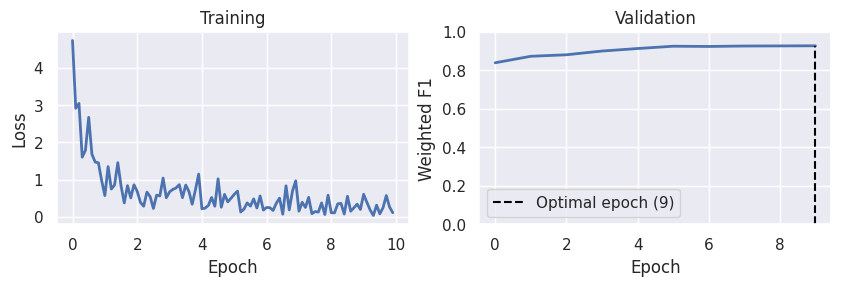

In [10]:
# Plot training loss and validation F1:
# -------------------------------------
plt.figure(figsize = (10, 2.5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(losses)) / n_epochs, losses, linewidth = 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(valid_f1s)) * check_freq, valid_f1s, linewidth = 2)
plt.vlines(optimal_epoch * check_freq, 0, valid_f1s[optimal_epoch], colors = 'black', linestyles = 'dashed', label = f'Optimal epoch ({optimal_epoch * check_freq})')
plt.xlabel('Epoch')
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.title('Validation')
plt.legend(loc = 'lower left')
plt.savefig('plot.png')
plt.show()

In [1]:
# Load the model which achieved the largest validation F1:
# --------------------------------------------------------
model = nn.DataParallel(EfficientNetB0(n_classes = 104, learnable_modules = ())).to(device)
model.load_state_dict(torch.load(f'./epoch{optimal_epoch}.pth'))

NameError: name 'nn' is not defined

In [12]:
# Submission:
# -----------
ids = []
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        ids.append(y[0])
        mean_logp = model(x.view(-1, 3, 300, 300).to(device)).mean(dim = 0)
        preds.append(torch.argmax(mean_logp).item())
submission = pd.DataFrame({'id': ids, 'label': preds})
submission.to_csv('submission.csv', index = False)
submission.head()

,id,label
0,640bd467f,103
1,4fd5cd91f,22
2,0d48d68af,73
3,0b619448f,103
4,ebd745005,13
